In [1]:
!echo "hello"

"hello"


# load and view data

In [2]:
from __future__ import print_function, division
from collections import OrderedDict
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import time
from numpy import savez_compressed


torch.set_default_tensor_type(torch.cuda.FloatTensor)

x = np.load('./../data/gsn_img_uint8.npy')
y = np.load('./../data/gsn_msk_uint8.npy')

x_test = np.load('./../data/test_gsn_image.npy')
y_test = np.load('./../data/test_gsn_mask.npy')

In [3]:
print(x.shape, y.shape)

(2000, 128, 128, 3) (2000, 128, 128, 1)


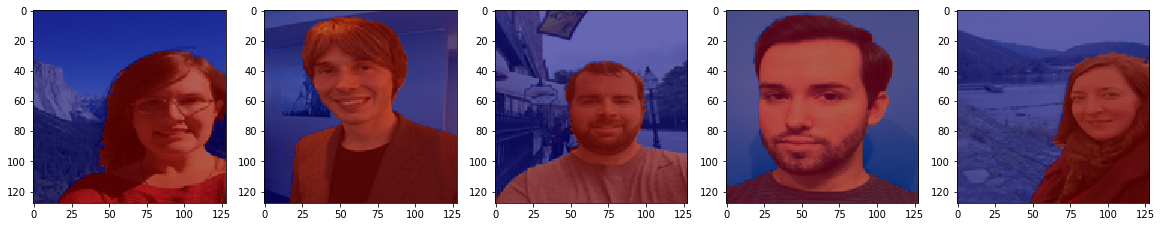

In [4]:
from matplotlib import pyplot as plt
torch.set_default_tensor_type(torch.cuda.FloatTensor)

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if(imgs.shape[3] == 1) :
            imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
        sub.imshow(imgs[i], interpolation='nearest')

def imshow_masked(samples):
    n = len(samples)
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        image = samples[i]['image']
        mask = samples[i]['mask']
        if torch.is_tensor(image) :
            image = image.permute(1,2,0)
        if torch.is_tensor(mask) :
            mask = mask.permute(1,2,0)
        mask = mask.reshape((mask.shape[0], mask.shape[1]))
        sub.imshow(image, interpolation='nearest')
        sub.imshow(mask, interpolation='nearest', cmap='jet', alpha=0.6)
    
start = 0
end = 5
samples = [{'image' : a, 'mask' : b} for a,b in zip(x[start:end], y[start:end])]
imshow_masked(samples)

# Transforms

In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        resized_mask = transform.resize(mask, (new_h, new_w))
        mask = (resized_mask > 0.5).astype(resized_mask.dtype)

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}
    
    
class HFlip(object):
    """Flip image horizontaly.
    """

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        return {'image': np.flip(image, 0), 'mask': np.flip(mask,0)}


def tf_rotate_cw(img):
    extra = 0
    if len(img.shape) == 4 :
        extra = 1
    return img.transpose(1 + extra,2 + extra).flip(1 + extra)

def tf_rotate_ccw(img):
    return tf_rotate_cw(tf_rotate_cw(tf_rotate_cw(img)))    
    
def tf_Hflip(img, cw=True):
    return img.flip(len(img.shape) - 1)

def tf_Vflip(img, cw=True):
    return img.flip(len(img.shape) - 2)
    
class Rotate(object):
    """Flip image horizontaly.
    """

    def __init__(self, clockwise=True):
        self.cw = clockwise
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        if self.cw :
            img_CW = image.swapaxes(1,0)[:,::-1,...]
            mask_CW = mask.swapaxes(1,0)[:,::-1,...]
            sample = {'image': img_CW, 'mask': mask_CW}
        
        else :
            img_CCW = image.swapaxes(1,0)
            mask_CCW = mask.swapaxes(1,0)
            sample = {'image': img_CCW, 'mask': mask_CCW}

        return sample

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = TF.to_tensor(image.copy())
        
        mask = TF.to_tensor(mask.copy())
        return {'image': image.float(),
                'mask': mask.float()}

# **Dataset**

In [6]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
class myDataset(Dataset):
    """Images and masks dataset."""

    def __init__(self, gsn_img, gsn_mask, transform=None):
        """
        Args:
            gsn_img (np.array): numpy array of images
            gsn_mask (np.array): numpy array of masks
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = gsn_img
        self.masks = gsn_mask
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample


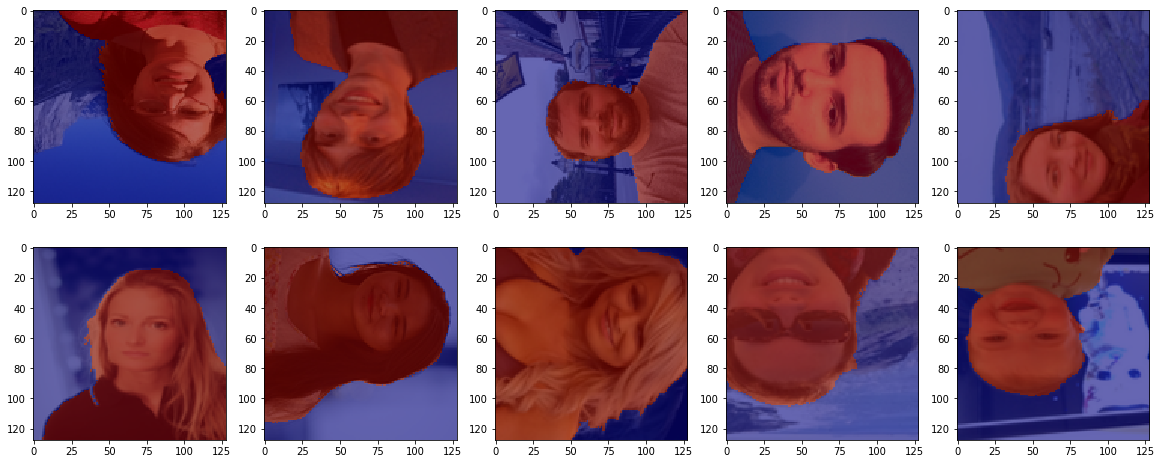

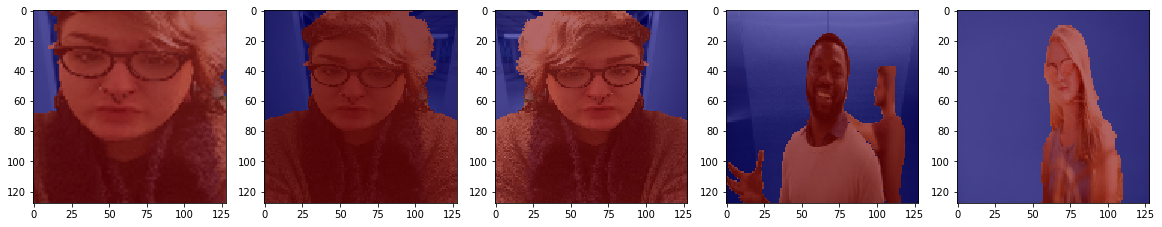

In [7]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

crop = transforms.Compose([Rescale(150),
                               RandomCrop(128)])
flip = HFlip()
rot_cw = Rotate()
rot_ccw = Rotate(clockwise=False)

all_transforms = transforms.Compose([
    transforms.RandomApply([crop], p=0.5),
    transforms.RandomApply([transforms.RandomChoice([flip, rot_cw, rot_ccw ])], p=0.7),
    ToTensor()])


toten = ToTensor()

numpy_dataset = myDataset(x, y)
train_dataset_aug = myDataset(x, y, transform=all_transforms)
test_dataset = myDataset(x_test, y_test, transform=toten)

# imshow_masked([train_dataset[i] for i in range(5)])

imshow_masked([train_dataset_aug[i] for i in range(10)])
imshow_masked([test_dataset[i] for i in range(5)])


In [8]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

trainloader = DataLoader(train_dataset_aug, batch_size=4,
                        shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


tensor([[[0.1294, 0.1373, 0.0667,  ..., 0.5725, 0.5765, 0.5529],
         [0.0784, 0.1216, 0.1098,  ..., 0.5922, 0.5922, 0.5569],
         [0.0667, 0.0588, 0.1059,  ..., 0.6157, 0.5961, 0.5725],
         ...,
         [0.0980, 0.1059, 0.1098,  ..., 0.3098, 0.3176, 0.3569],
         [0.0588, 0.0824, 0.0980,  ..., 0.2863, 0.2667, 0.2784],
         [0.0588, 0.0549, 0.0863,  ..., 0.3490, 0.3137, 0.3216]],

        [[0.4863, 0.4078, 0.2863,  ..., 0.5804, 0.5882, 0.5608],
         [0.4000, 0.3961, 0.3216,  ..., 0.6118, 0.6118, 0.5725],
         [0.3373, 0.3294, 0.3216,  ..., 0.6431, 0.6235, 0.5961],
         ...,
         [0.1373, 0.1451, 0.1490,  ..., 0.2863, 0.2941, 0.3333],
         [0.1020, 0.1294, 0.1373,  ..., 0.2588, 0.2392, 0.2549],
         [0.0980, 0.1020, 0.1216,  ..., 0.3216, 0.2863, 0.2980]],

        [[0.1176, 0.1255, 0.0510,  ..., 0.6588, 0.6667, 0.6275],
         [0.0667, 0.1098, 0.0941,  ..., 0.6941, 0.6902, 0.6392],
         [0.0588, 0.0471, 0.0902,  ..., 0.7333, 0.7059, 0.

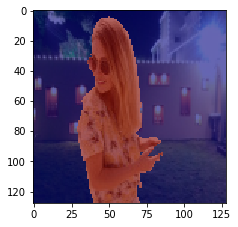

In [9]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

dataiter = iter(testloader)
one_data = dataiter.next()
img_batch = one_data['image']
mask_batch = one_data['mask']
print(img_batch.shape)
img_batch = tf_rotate_ccw(tf_rotate_cw(img_batch))
print(img_batch.shape)
# mask_batch = tf_Hflip(mask_batch)

imshow_masked([{'image':img_batch[i], 'mask':mask_batch[i]} for i in range(1)])
img_batch[0]

# Network

In [10]:
tsf = [(tf_rotate_cw, tf_rotate_ccw), (tf_rotate_ccw, tf_rotate_cw), (tf_Hflip, tf_Hflip)]
torch.set_default_tensor_type(torch.cuda.FloatTensor)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()
        self.augumented = False
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
    
    def set_augumented(self, val):
        self.augumented = val
    
    def forward(self, x):
        if self.augumented :
            no_aug = self.fwd(x)
            for (tr, rev_tr) in tsf :
                no_aug += rev_tr(self.fwd(tr(x)))
            return ((no_aug / (len(tsf) + 1)) > 0.5).float()
        else :
            return self.fwd(x)
            
    def fwd(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Training

In [11]:
epochs = 60
lr = 0.00005
torch.set_default_tensor_type(torch.cuda.FloatTensor)

def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))



class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

def IOU(preds, truth):
    intersection = np.logical_and((preds > 0.5) == True,(truth > 0.5) == True).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection/union
    

imgs_log = []
    
unet = UNet(in_channels=3, out_channels=1).float()


crop = transforms.Compose([Rescale(150), RandomCrop(128)])
rot_cw = Rotate(True)
rot_ccw = Rotate(False)
flip = HFlip()



        


def train_validate():
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    unet.to(device)
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train_log = []
    loss_valid_log = []
    IOU_log = []
    
    loss_train = []
    loss_valid = []
    
    dsc_loss = DiceLoss()
    
    step = 0
    
    start_train= time.time()
    for epoch in range(epochs):
        start_epoch = time.time()
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
                unet.set_augumented(False)
            else:
                unet.eval()
                unet.set_augumented(True)
    
            validation_pred = []
            validation_true = []
            IOU_avg_sum = 0
            batches = 0
            
            if phase == "train":
                en = enumerate(trainloader, 0)
            else :
                en = enumerate(testloader, 0)
            
            for i, data in en:
                if phase == "train":
                    step += 1
                
                x = data['image']
                y_true = data['mask']
                
                
                
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
            
                    y_pred = unet(x)
                    
                    loss = dsc_loss(y_pred, y_true)
                    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                        imgs_log.append((y_true_np[0],y_pred_np[0]))
                        
                        batch_size = y_pred_np.shape[0]
                        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
                        IOU_avg_sum += sum(IOU_batch)/batch_size
                        batches += 1
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                loss_train_log.append(np.mean(loss_train))
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                iou = IOU_avg_sum/batches
                print("IOU=", iou)
                IOU_log.append(iou)
                loss_valid_log.append(np.mean(loss_valid))
                log_loss_summary(loss_valid, epoch, prefix="val_")
                loss_valid = []
        end_epoch = time.time()
        total_so_far = (end_epoch - start_train)
        time_per_epoch = total_so_far / (epoch + 1)
        eta = (epochs - epoch - 1) * time_per_epoch
        print("total:{0}\tepoch{1}:{2}\tavg_per_epoch{3}\tETA:{4}".format(total_so_far, (epoch + 1), (end_epoch - start_epoch),time_per_epoch, eta))
    return loss_train_log,loss_valid_log, IOU_log
    

In [12]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

start = time.time()

train_log,test_log, iou_log =  train_validate()

end = time.time()
elapsed = end - start
print("elapsed", elapsed)

plt.plot(train_log, label='train')
plt.plot(test_log, label='test')
plt.title("loss vs epoch")
plt.legend()
plt.show()

plt.plot(iou_log, label="IOU")
plt.title("IOU on test set vs epoch")
plt.show()

torch.save(unet.state_dict(), 'model50_aug.mod')
# save to npy file
savez_compressed('train_log50.npz', np.array(train_log))
savez_compressed('test_log50.npz', np.array(test_log))
savez_compressed('iou_log50.npz', np.array(iou_log))


epoch 1 | loss: 0.3350744889974594
IOU= 0.6875212688312714
epoch 1 | val_loss: 0.2018146697282791
total:97.63600945472717	epoch1:97.63600945472717	avg_per_epoch97.63600945472717	ETA:58483.96966338158
epoch 2 | loss: 0.2692319427728653
IOU= 0.7016069661565072
epoch 2 | val_loss: 0.1952340861558914
total:190.76032304763794	epoch2:93.12381434440613	avg_per_epoch95.38016152381897	ETA:57037.336591243744
epoch 3 | loss: 0.23431887674331664
IOU= 0.7491670610705983
epoch 3 | val_loss: 0.15872880589962005
total:286.6937005519867	epoch3:95.93337750434875	avg_per_epoch95.56456685066223	ETA:57052.04640984535
epoch 4 | loss: 0.2037761273384094
IOU= 0.7496498705763734
epoch 4 | val_loss: 0.1575938024520874
total:380.39286160469055	epoch4:93.69916105270386	avg_per_epoch95.09821540117264	ETA:56678.53637909889
epoch 5 | loss: 0.17653147101402283
IOU= 0.7480615088037078
epoch 5 | val_loss: 0.16913043904304503
total:481.5662581920624	epoch5:101.17339658737183	avg_per_epoch96.31325163841248	ETA:57306.3847

KeyboardInterrupt: 

# Results

In [20]:
torch.save(unet.state_dict(), 'model60_smaller_step.mod')

In [ ]:
asdfdsfsdafsffassdsfdsfd


device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

unet = UNet(in_channels=3, out_channels=1)
unet.load_state_dict(torch.load('model30_noaug.mod'))
unet.to(device)
print("loaded")

In [ ]:
tsf = [(tf_rotate_cw, tf_rotate_ccw), (tf_rotate_ccw, tf_rotate_cw), (tf_Hflip, tf_Hflip)]

def augumentedPred(image, unet):
    no_aug = unet(image)
    
    for (tr, rev_tr) in tsf :
        no_aug += rev_tr(unet(tr(image)))
    return no_aug / (len(tsf) + 1)

In [13]:
unet.set_augumented(True)
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

In [ ]:
dataiter = iter(trainloader)
one_data = dataiter.next()
image = one_data['image'].to(device)
y_true = one_data['mask'].to(device)

In [ ]:
unet.set_augumented(False)
y_pred = unet(image)

imshow_masked([{'image':image[0].cpu(), 'mask':y_true[0].cpu()}])
imshow_masked([{'image':image[0].detach().cpu(), 'mask':y_pred[0].detach().cpu()}])


tr, rev_tr = tsf[0]
y_pred2 = rev_tr(unet(tr(image)))

print(y_pred2.min())

imshow_masked([{'image':image[0].detach().cpu(), 'mask':y_pred2[0].detach().cpu()}])

In [ ]:
def to_mask(mask):
    return (mask > 0.5).float()




dataiter = iter(trainloader)
one_data = dataiter.next()
image = one_data['image'].to(device)
y_true = one_data['mask'].to(device)

unet.set_augumented(False)
y_pred = unet(image)

imshow_masked([{'image':image[i].cpu(), 'mask':y_true[i].cpu()} for i in range(4)])
imshow_masked([{'image':image[i].cpu(), 'mask':y_pred[i].detach().cpu()} for i in range(4)])

unet.set_augumented(True)
y_pred2 = unet(image)

imshow_masked([{'image':image[i].cpu(), 'mask':to_mask(y_pred2[i].detach().cpu())} for i in range(4)])

In [15]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

dsc_loss = DiceLoss()

def pixel_acc(y_pred, y_true):
    same = (np.logical_and((y_pred > 0.5) == 1 , (y_true > 0.5) == 1)).sum() + (np.logical_and((y_pred > 0.5) ==0 , (y_true > 0.5) == 0)).sum()
    return (same / (y_pred.shape[0] * y_pred.shape[1] * y_pred.shape[2]))



def validate():
    batches = 0
    unet.set_augumented(True)
    loss_valid = []
    validation_pred = []
    validation_true = []
    pixel_acc_sum = 0
    pixel_acc_batch = []
    IOU_avg_sum = 0
    for i, data in enumerate(testloader, 0):
        if i % 40 == 39 :
            print("done", i)
        x = data['image']
        y_true = data['mask']

        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        loss = dsc_loss(y_pred, y_true)
        
        loss_valid.append(loss.item())
        y_pred_np = y_pred.detach().cpu().numpy()
        validation_pred.extend(
            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
        )
        y_true_np = y_true.detach().cpu().numpy()
        validation_true.extend(
            [y_true_np[s] for s in range(y_true_np.shape[0])]
        )

        imgs_log.append((y_true_np[0],y_pred_np[0]))

        batch_size = y_pred_np.shape[0]
        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
        pixel_acc_batch = [pixel_acc(y_pred_np[i],y_true_np[i]) for i in range(batch_size)]
        IOU_avg_sum += sum(IOU_batch)/batch_size
        pixel_acc_sum += sum(pixel_acc_batch)/batch_size
        batches += 1
    
    iou = IOU_avg_sum/batches
    print("IOU=", iou)
    pix = pixel_acc_sum/batches
    print("PIX_ACC=", pix)
    log_loss_summary(loss_valid, 0, prefix="val_")

    unet.set_augumented(False)
    
    return iou

# validate()

# VALIDATION

In [ ]:
trained = []

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
 
seqLoaderTrain = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)


dsc_loss = DiceLoss()
    
with torch.set_grad_enabled(False):
    for i, data in enumerate(seqLoaderTrain, 0):
        if i % 500 == 499 :
            print('processed', i)
        x = data['image']
        y_true = data['mask']
        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        y_pred = y_pred.cpu()
        y_true = y_true.cpu()
        loss = IOU(y_pred, y_true)
        trained.append((loss, i))

In [16]:
tested = []
test_dataset = myDataset(x_test, y_test, transform=ToTensor())


seqLoaderTest = DataLoader(test_dataset, batch_size=1,
                        shuffle=False)

with torch.set_grad_enabled(False):
    for i, data in enumerate(seqLoaderTest, 0):
        if i % 100 == 99 :
            print('processed', i+1)
        x = data['image']
        y_true = data['mask']
        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        y_pred = y_pred.cpu()
        y_true = y_true.cpu()
        pix = pixel_acc(y_pred[0].numpy(), y_true[0].numpy())
        iou = IOU(y_pred, y_true)
        tested.append((pix, iou, i))

processed 100
processed 200
processed 300
processed 400
processed 500


In [ ]:
test_dataset[101]

In [ ]:
data = test_dataset[101]
x = data['image']
y_true = data['mask']
x, y_true = x.to(device), y_true.to(device)
y_pred = unet(x)
y_pred = y_pred.cpu()
y_true = y_true.cpu()
pix = pixel_acc(y_pred[0].numpy(), y_true[0].numpy())

In [17]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
unet.set_augumented(True)

def show_compared(data):
    x = data['image']
    y_true = data['mask']
    x, y_true = x.to(device), y_true.to(device)
    y_pred = unet(x.reshape(1,x.shape[0], x.shape[1],x.shape[2]).float())
    y_pred_numpy = y_pred[0].cpu().detach().permute(1,2,0).numpy()
    
    y_true_np = y_true.detach().cpu().permute(1,2,0).numpy()
    
#     intersection = np.logical_and((y_pred_numpy > 0.5) == True,(y_true_np > 0.5) == False).astype('uint8')
    intersection = ((y_pred_numpy > 0.5) != (y_true_np > 0.5)).astype('uint8')
    print('pix', intersection.sum() / (y_true_np.shape[0]*y_true_np.shape[1]*y_true_np.shape[2]))
    
    pred_sample = {'image': x.detach().cpu(), 'mask':y_pred[0].detach().cpu()}
    
    diff = {'image': np.ones((128,128,3)).astype('uint8')*255, 'mask':intersection}
    imshow(data['image'].permute(1,2,0))
    imshow_masked([data,pred_sample, diff])

In [18]:


trained_sorted = sorted(tested, key = lambda a : a[0])
trained_sorted[10:]
sum([x for (x,_,_) in tested])/len(tested)

0.931206298828125

pix 0.00408935546875


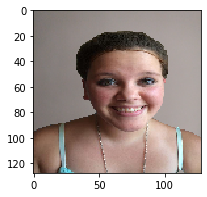

pix 0.0040283203125


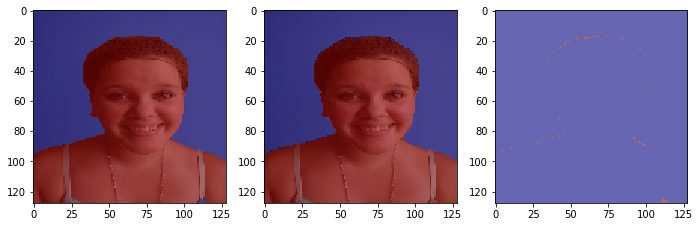

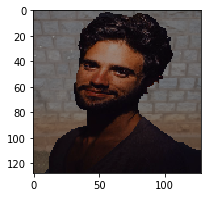

pix 0.00396728515625


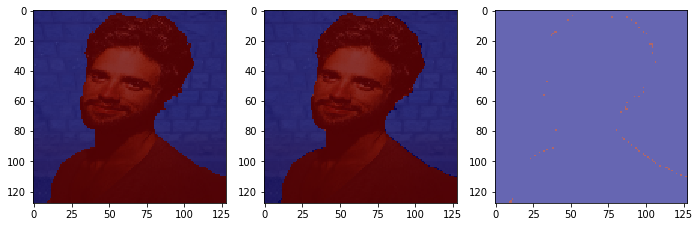

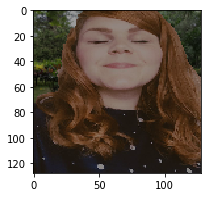

pix 0.00396728515625


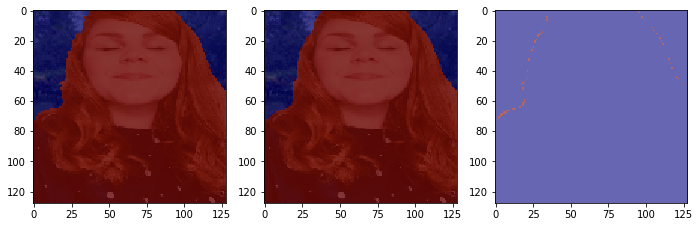

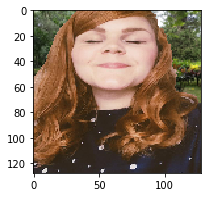

pix 0.003662109375


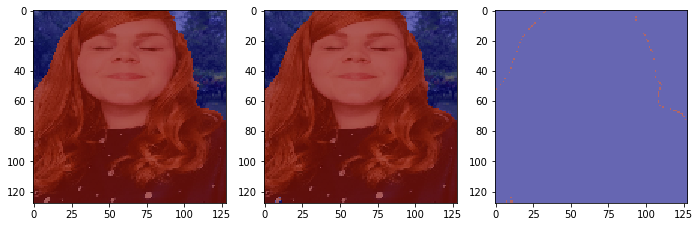

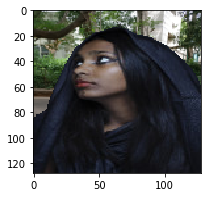

pix 0.00299072265625


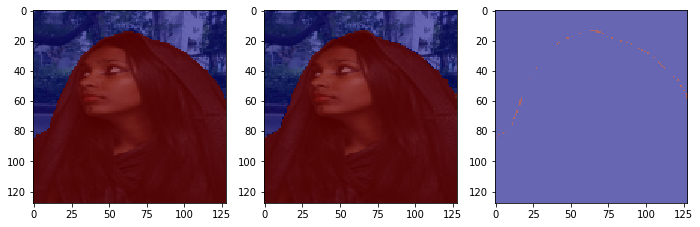

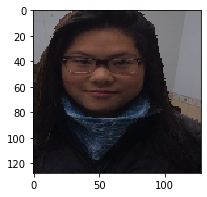

pix 0.00299072265625


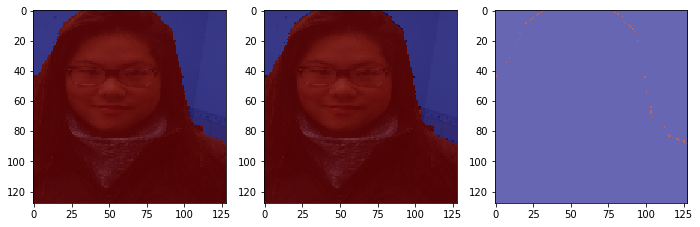

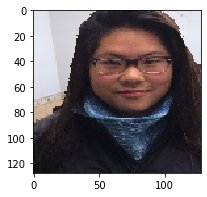

pix 0.0025634765625


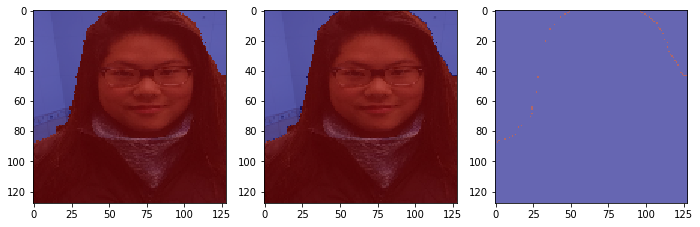

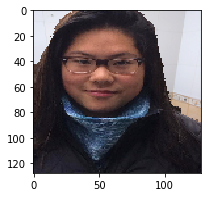

pix 0.00250244140625


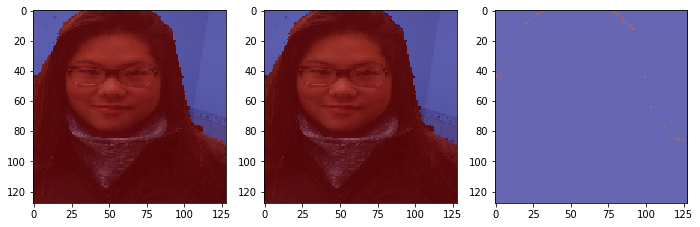

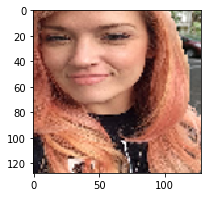

pix 0.0018310546875


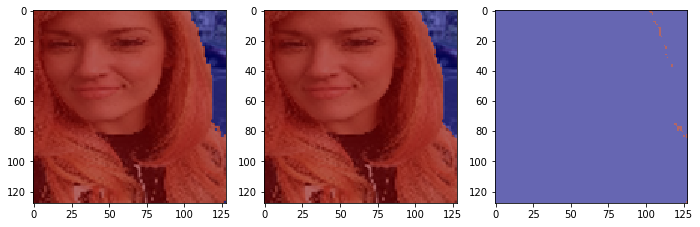

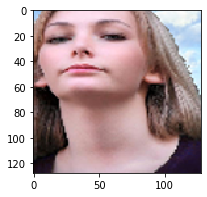

worst
pix 0.4669189453125


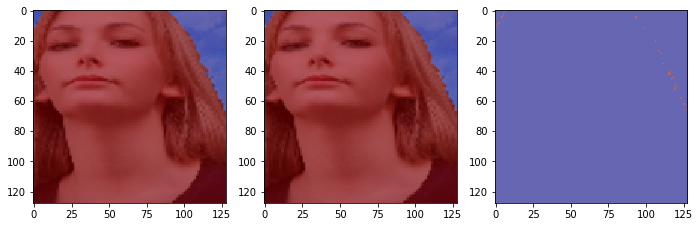

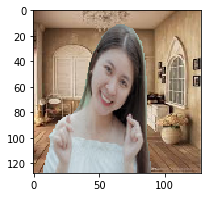

pix 0.429443359375


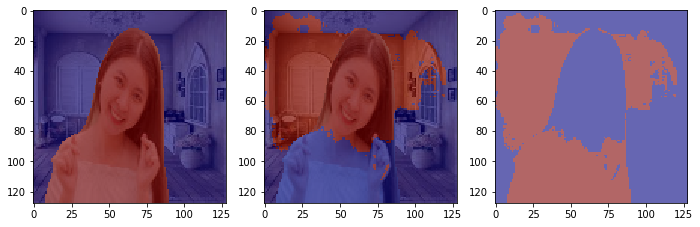

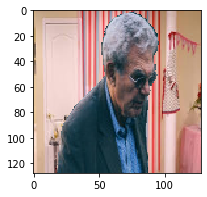

pix 0.41448974609375


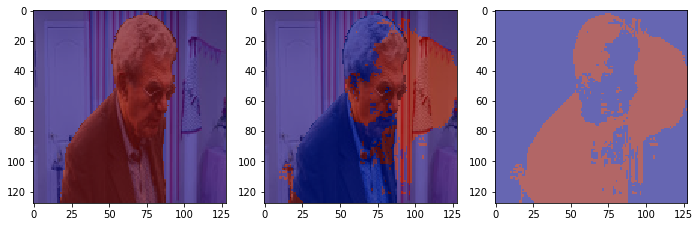

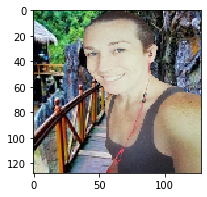

pix 0.41400146484375


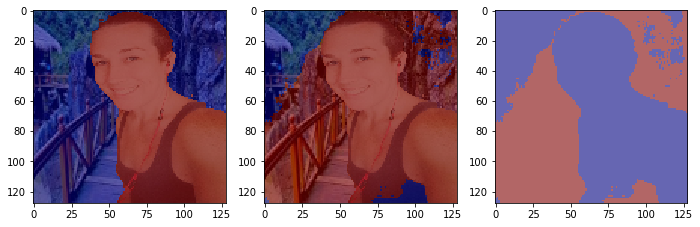

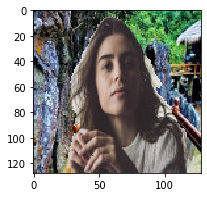

pix 0.4097900390625


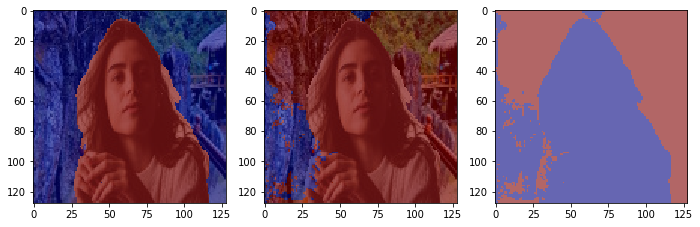

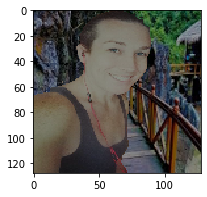

pix 0.40362548828125


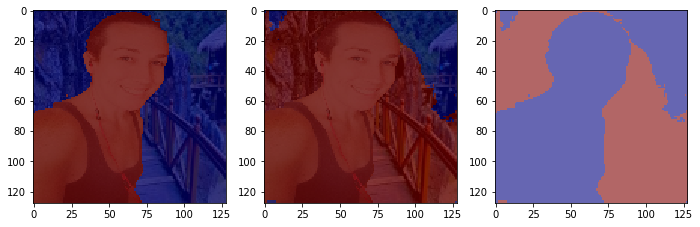

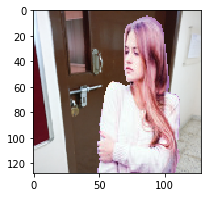

pix 0.40277099609375


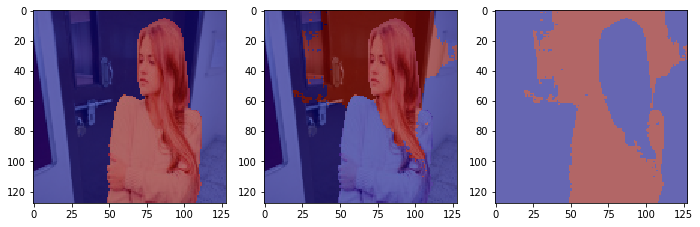

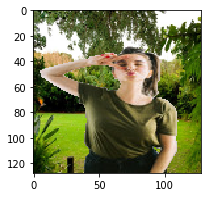

pix 0.39154052734375


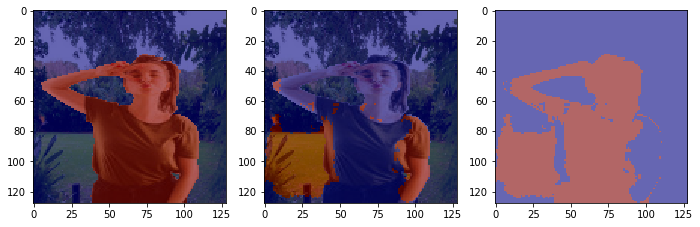

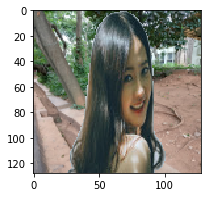

pix 0.3504638671875


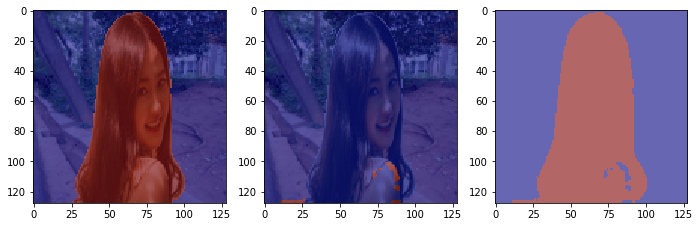

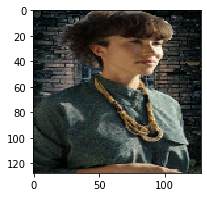

pix 0.3448486328125


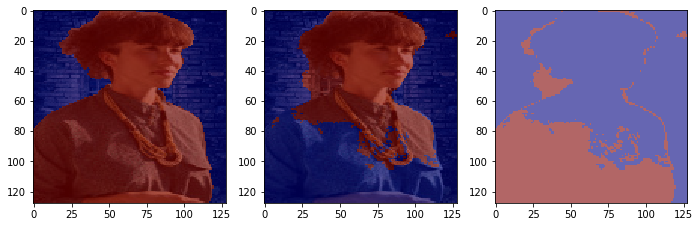

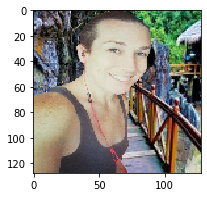

[None, None, None, None, None, None, None, None, None, None]

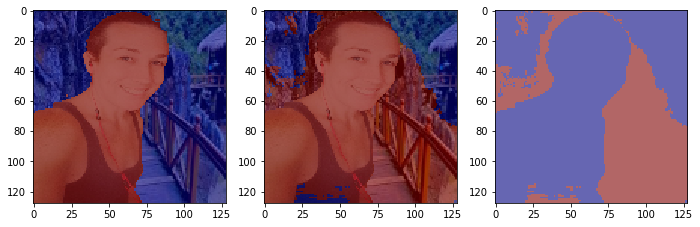

In [19]:
[show_compared(test_dataset[i]) for (_,_,i) in trained_sorted[-10:] ]

time.sleep(3)
print("worst")

[show_compared(test_dataset[i]) for (_,_, i) in trained_sorted[:10] ]

In [ ]:
IOU(preds,trus)

In [ ]:
print(((preds > 0.5) ==  (trus > 0.5)).sum().item() / (128*128))

In [ ]:
torch.save(unet.state_dict(), 'model30.mod')